# Proyecto final A/B - Luis Gutiérrez

In [289]:
# Importar librerías

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [290]:
# Importar datasets

df_campaigns = pd.read_csv('ab_project_marketing_events_us.csv')
df_user_events = pd.read_csv('final_ab_events_upd_us.csv')
df_new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
df_ab = pd.read_csv('final_ab_participants_upd_us.csv')

## Análisis inicial

### Marketing events

In [291]:
df_campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [292]:
df_campaigns.sample(5)

,name,regions,start_dt,finish_dt
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


In [293]:
# Cambiar datatype de las columnas de fecha

dt_cols = ['start_dt', 'finish_dt']

for col in dt_cols:
    df_campaigns[col] = pd.to_datetime(df_campaigns[col], format = '%Y-%m-%d')

# Separar las regiones y tener un renglón para cada evento/region

df_campaigns['regions'] = df_campaigns['regions'].str.replace(' ', '').str.split(',')
df_campaigns = df_campaigns.explode('regions')

### Eventos de usuario

In [294]:
df_user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [295]:
df_user_events.sample(5)

,user_id,event_dt,event_name,details
382967,3D9C6336B01B96CC,2020-12-22 00:09:42,login,NaN
384046,59C51424645FE4ED,2020-12-23 21:02:30,login,NaN
339110,7A1D69361DE05CCE,2020-12-19 19:26:29,login,NaN
332356,16336FDC84BF46FB,2020-12-18 20:22:48,login,NaN
349599,3B6EFBCE997C73EB,2020-12-20 20:56:20,login,NaN


In [296]:
# Columna event_dt a datatime

df_user_events['event_dt'] = pd.to_datetime(df_user_events['event_dt'])

df_user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


- Los valores ausentes en la columna details están asociados a que debe ser una venta y se le coloca el monto en dicha columna, revisemos si no hay problemas

In [297]:
df_user_events.query('event_name == "purchase"').info()

<class 'pandas.core.frame.DataFrame'>
Index: 60314 entries, 0 to 60313
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     60314 non-null  object        
 1   event_dt    60314 non-null  datetime64[ns]
 2   event_name  60314 non-null  object        
 3   details     60314 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.3+ MB


- Confirmamos que todas las purchase tienen un detail asociado.

## Nuevos usuarios

In [298]:
df_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [299]:
df_new_users.sample(5)

,user_id,first_date,region,device
15767,F9BD44FADC421004,2020-12-21,EU,PC
31388,84A02497E3232F5B,2020-12-23,EU,PC
10990,7E81DBB1530EB04B,2020-12-21,EU,Android
11923,1549907813A9ED35,2020-12-21,EU,Android
29070,DBF642D2D4B4A8BA,2020-12-16,CIS,Android


In [300]:
# Columna first_date a datatime

df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'], format = '%Y-%m-%d')

df_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


### Datos prueba AB

In [301]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [302]:
df_ab.sample(5)

,user_id,group,ab_test
9273,A0851310010B30D4,B,interface_eu_test
9062,C9EEE28A7D84B483,A,interface_eu_test
12084,DBDF711A9D2C09C9,A,interface_eu_test
10474,94C002F082F41235,B,interface_eu_test
441,9CC7BABE25F1E408,A,recommender_system_test


In [303]:
# Revisamos duplicados en usuarios para ver que no haya problemas

df_ab_dupl = df_ab[df_ab['user_id'].duplicated(keep=False)].sort_values(by='user_id')

- Tenemos usuarios que pertenecieron a grupos A B, a puro grupo A o a puro grupo B, hablando de ambas pruebas (interface o recommender system).

In [304]:
# Revisamos duplicados explícitos

df_ab_dupl.duplicated().sum() 

np.int64(0)

- Nos regresa 0, están todos los usuarios divididos o en A o B y o en interface o recommender

## Analisis exploratorio

- Ya que la prueba tiene datos del final del año 2020, considero que sería bueno dividir la temporalidad en días.

In [305]:
# Agregar columnas de dates al dataframe Campaigns

df_campaigns['start_month'] = df_campaigns['start_dt'].dt.month
df_campaigns['start_day'] =  df_campaigns['start_dt'].dt.day
df_campaigns['end_month'] = df_campaigns['finish_dt'].dt.month
df_campaigns['end_day'] = df_campaigns['finish_dt'].dt.day

# Agregar columnas de dates al dataframe Events

df_user_events['event_day'] = df_user_events['event_dt'].dt.day

# Agregar columnas de dates al dataframe New Users

df_new_users['first_day'] = df_new_users['first_date'].dt.day
df_new_users['first_month'] = df_new_users['first_date'].dt.month

- Embudo de eventos

In [306]:
event_funnel = df_user_events.groupby('event_name').agg(num_users = ('user_id','count')).sort_values('num_users', ascending=False)

# Tasa de conversión de una etapa a otra

event_funnel['conversion_rate'] = event_funnel['num_users'] / event_funnel['num_users'].shift(1)

# Conversión acumulada desde el inicio

event_funnel['cumulative_conversion'] = event_funnel['num_users'] / event_funnel['num_users'].iloc[0]

event_funnel

,num_users,conversion_rate,cumulative_conversion
event_name,,,
login,182465,NaN,1.000000
product_page,120862,0.662385,0.662385
purchase,60314,0.499032,0.330551
product_cart,60120,0.996783,0.329488


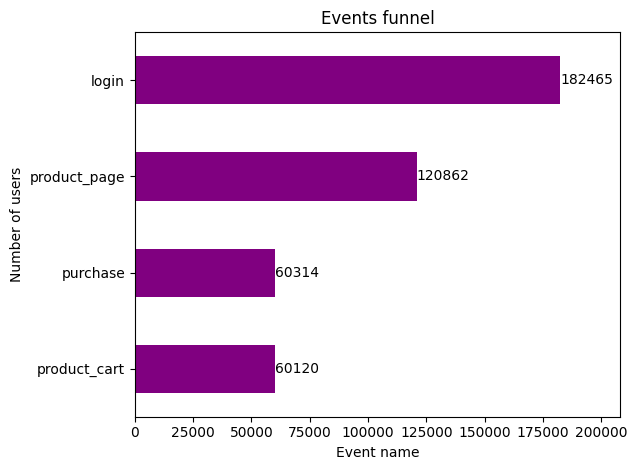

In [307]:
# Gráfico del embudo

event_funnel['num_users'].plot(kind='barh', color='purple')

plt.title('Events funnel')
plt.xlabel('Event name')
plt.ylabel('Number of users')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.xlim([0,208000])

for i, (value, name) in enumerate(zip(event_funnel['num_users'], event_funnel.index)):
    plt.text(value + 5, i, str(value), va='center')

plt.show()

- Curiosamente, existen más compras que momentos de adjuntar productos al carrito; esto puede ser por compras que son directamente con un botón y no tanto compras que vayan acumulando varios productos

In [308]:
df_user_events[(df_user_events['event_name'] == 'product_cart') & (df_user_events['user_id'].duplicated(keep=False))].groupby('user_id').agg(num_events = ('event_dt','count')).sort_values('num_events', ascending=False)

,num_events
user_id,
7AD8C257F34EF098,10
D8A179719760ADA0,10
73E6A2E2A78FDF29,9
EE24C237DFB1ACEF,9
DFE346880E238754,9
...,...
6C0DC482ACAC0DDC,1
470564EDB9DB83F8,1
94823CF97FBC9CDA,1


- Tenemos usuarios que a lo largo de varios días adjuntan múltiples veces productos en su carrito, por eso está inflado el conteo de "product_cart"

- Número de eventos por usuarios clasificados por grupos
- Ya que la prueba que nos interesa es la de "recommender_system_test", nos quedaremos con esos valores

In [309]:
df_ab_real = df_ab.query('ab_test == "recommender_system_test"')

# Merge de la clasificación de usuarios con los eventos

df_events_ab = df_user_events.merge(df_ab_real, on='user_id', how='inner')

df_events_ab

,user_id,event_dt,event_name,details,event_day,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,7,A,recommender_system_test
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,7,A,recommender_system_test
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,7,B,recommender_system_test
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,7,A,recommender_system_test
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,7,B,recommender_system_test
...,...,...,...,...,...,...,...
23904,D21F0D4FDCD82DB2,2020-12-29 02:17:00,login,NaN,29,A,recommender_system_test
23905,96BDD55846D1F7F6,2020-12-29 16:53:42,login,NaN,29,A,recommender_system_test
23906,553BAE96C6EB6240,2020-12-29 14:09:14,login,NaN,29,A,recommender_system_test
23907,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,NaN,30,B,recommender_system_test


- Haremos nuevamente el embudo ahora únicamente con gente de la prueba AB

In [310]:
event_funnel_AB = df_events_ab.groupby('event_name').agg(num_users = ('user_id','count')).sort_values('num_users', ascending=False)

# Tasa de conversión de una etapa a otra

event_funnel_AB['conversion_rate'] = event_funnel_AB['num_users'] / event_funnel_AB['num_users'].shift(1)

# Conversión acumulada desde el inicio

event_funnel_AB['cumulative_conversion'] = event_funnel_AB['num_users'] / event_funnel_AB['num_users'].iloc[0]

event_funnel_AB

,num_users,conversion_rate,cumulative_conversion
event_name,,,
login,10837,NaN,1.000000
product_page,6702,0.618437,0.618437
purchase,3210,0.478962,0.296207
product_cart,3160,0.984424,0.291594


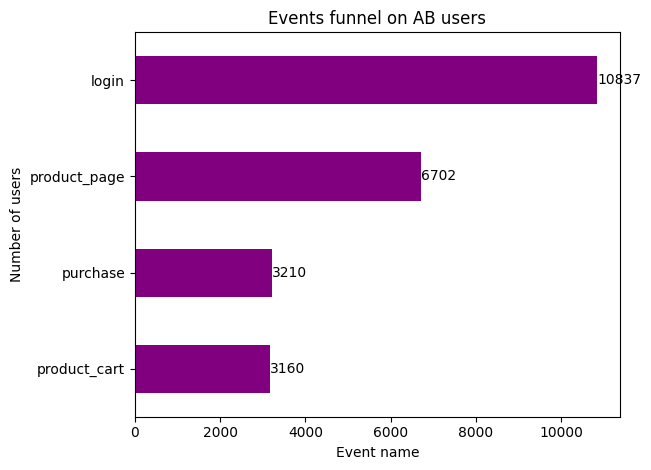

In [311]:
# Gráfico

event_funnel_AB['num_users'].plot(kind='barh', color='purple')

plt.title('Events funnel on AB users')
plt.xlabel('Event name')
plt.ylabel('Number of users')
plt.gca().invert_yaxis() 
plt.tight_layout()

for i, (value, name) in enumerate(zip(event_funnel_AB['num_users'], event_funnel_AB.index)):
    plt.text(value + 5, i, str(value), va='center')

plt.show()

- Tenemos la misma peculiaridad de más compras que agregaciones al carrito de compras.

In [312]:
# Numero de eventos por usuario

df_events_ab.groupby('group').agg(event_count = ('event_name','count'))

,event_count
group,
A,18627
B,5282


- Tenemos mucha más gente con eventos en el grupo A que en el grupo B, no obstante, ya que el objeto de estudio es la conversión, se puede adecuar el total por proporciones.

- Queremos también revisar si hay usuarios que aparezcan en ambas muestras (grupos)

In [313]:
df_events_ab.groupby('user_id').agg(number_of_groups = ('group','nunique')).sort_values('number_of_groups', ascending=False) # Confirmamos que solamente hay 1 grupo por usuario

,number_of_groups
user_id,
001064FEAAB631A1,1
AAB4D11666ADB943,1
AAD72B195EFC73A4,1
AAE1914BDB419328,1
AAE4A39A0DF719AD,1
...,...
55E1E5508B640E65,1
55F1DDF55DD42893,1
563FBD5282619D25,1


- Distribución de eventos por dia

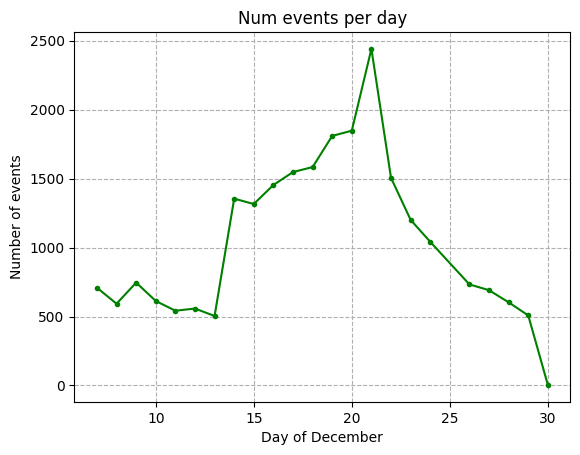

In [314]:
events_per_day = df_events_ab.groupby('event_day').agg(num_events = ('event_name','count'))

events_per_day.plot(kind='line', marker='.', legend=False, color='green')

plt.title('Num events per day')
plt.ylabel('Number of events')
plt.xlabel('Day of December')
plt.grid(linestyle='--')

plt.show()

- Conforme se acercaba la Navidad, subieron el número de eventos también, como era de esperar. Una vez terminada la festividad, empiezan a caer las interacciones en el sitio

## Prueba A/B

In [320]:
# Separacion de grupos

A_group = df_events_ab.query('group == "A"')
B_group = df_events_ab.query('group == "B"')

events_A = A_group.groupby(['event_name']).agg(num_events = ('event_dt','count')).sort_values('num_events', ascending=False)
events_B = B_group.groupby(['event_name']).agg(num_events = ('event_dt','count')).sort_values('num_events', ascending=False)

# Conversion rates en cada grupo

events_A['conversion_rate'] = events_A['num_events'] / events_A['num_events'].shift(1)
events_B['conversion_rate'] = events_B['num_events'] / events_B['num_events'].shift(1)


In [326]:
# Tabla grupo A

events_A

,num_events,conversion_rate
event_name,,
login,8272,NaN
product_page,5328,0.644101
purchase,2545,0.477665
product_cart,2482,0.975246


In [327]:
# Tabla grupo B

events_B

,num_events,conversion_rate
event_name,,
login,2565,NaN
product_page,1374,0.535673
product_cart,678,0.493450
purchase,665,0.980826


- A una primera vista, parece ser que los grupos no son muy diferentes en cuanto a conversiones; si bien es cierto que el funnel de un grupo va en orden diferente al otro, en los números podemos ver masomenos la misma conversión al momento de hacer una compra

In [321]:
# Funcion para hacer la prueba en cada etapa de conversión

def proportionsTest(countA, countB, totalA, totalB):
    
    count = [countB, countA]
    nobs = [totalB, totalA]

    stat, pval = proportions_ztest(count, nobs, alternative='larger')

    if pval < 0.05:
        return f"Rechazamos hipótesis nula, Z = {stat:.4f}, p-value = {pval:.4f}"
    else:
        return f"No podemos rechazar la hipótesis nula,  Z = {stat:.4f}, p-value = {pval:.4f}"

- Ho = La tasa de conversión es igual entre ambos grupos (A y B)
- Ha = La tasa de conversión es mayor en el grupo B

In [322]:
# Product_page

total_A = events_A['num_events'].sum()
total_B = events_B['num_events'].sum()

proportionsTest(events_A.loc['product_page', 'num_events'], events_B.loc['product_page', 'num_events'], total_A, total_B)



'No podemos rechazar la hipótesis nula,  Z = -3.7002, p-value = 0.9999'

In [323]:
# Purchase

proportionsTest(events_A.loc['purchase', 'num_events'], events_B.loc['purchase', 'num_events'], total_A, total_B)

'No podemos rechazar la hipótesis nula,  Z = -2.0190, p-value = 0.9783'

In [324]:
# Product cart

proportionsTest(events_A.loc['product_cart', 'num_events'], events_B.loc['product_cart', 'num_events'], total_A, total_B)

'No podemos rechazar la hipótesis nula,  Z = -0.9257, p-value = 0.8227'

## Conclusiones

- Existió más interacción en la página web a raiz de la cercanía a las fiestas navideñas.
- Considero que la prueba A/B no tuvo suficiente duración y que se aplicó en un momento complicado por ser cierre de año.
- Con los datos vistos a secas, se alcanza a ver que no parece haber diferencia entre el grupo A y el grupo B al momento de convertir en las diferentes etapas del embudo.
- Realizando la prueba de hipótesis (Z test), confirmamos que las proporciones entre etapas son estadisticamente iguales.
- Si se requiere evaluar el comportamiento de la nueva interfaz (EU) se tendría que especificar en lo solicitado al inicio del análisis, ya que solamente se requiere evaluar el "recommender system"